<a href="https://colab.research.google.com/github/sumanthpavan54/Facemask_Detection/blob/main/Augemented_pro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **DATA PREPARATION**

In [38]:
from tensorflow.keras.applications import mobilenet_v2, InceptionV3, InceptionResNetV2, VGG16, VGG19
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import xml.etree.ElementTree as xet#creating an xml parser to traverse the xml file and getting the necessary fields
import cv2
import matplotlib.pyplot as plt
from glob import glob#helps to read the corresponding files from the directory in the form of list
import numpy as np
from keras.preprocessing.image import ImageDataGenerator#does augmentation
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import make_scorer
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

Retriving all the xml files from the google drive

In [ ]:
lis_xml = glob("/content/drive/MyDrive/preview/*.xml")#helps to get all the xml files present the given path

In [ ]:
len(lis_xml)

2130

In [ ]:
test = lis_xml[1600:1700]

Limiting to 1500 xml files only due to limited hardware componenets for better results

In [ ]:
li_xml = lis_xml[0:1500]

In [ ]:
len(li_xml)

1500

Constructing a pandas dataframe by parsing all the xml files loaded into the li_xml

In [ ]:
data = dict(images=[],xmin=[],xmax=[],ymin=[],ymax=[])#dictionary which stores image_name and its path and its bounding boxes values by parsing the xml
for filename in li_xml:
  info = xet.parse(filename)#creating a parser for the current xml file
  root = info.getroot()#getting a root, so that we can traverse using this root to read and manipulate the content
  img_name = root.find('filename').text
  img_path = "/content/drive/MyDrive/preview/"+img_name
  data['images'].append(img_path)
  member_object = root.find("object")#finding the "object" tag in the given xml file
  labels_info = member_object.find("bndbox")#finding the "bndbox" tage under the "object" tag
  xmin = int(labels_info.find('xmin').text)#reading the "xmin" value under the "bndbox" tag
  xmax = int(labels_info.find('xmax').text)
  ymin = int(labels_info.find('ymin').text)
  ymax = int(labels_info.find('ymax').text)
  data['xmin'].append(xmin)
  data['xmax'].append(xmax)
  data['ymin'].append(ymin)
  data['ymax'].append(ymax)

In [ ]:
df = pd.DataFrame(data)

In [ ]:
df

,images,xmin,xmax,ymin,ymax
0,/content/drive/MyDrive/preview/car_0_4586.jpeg,36,451,262,472
1,/content/drive/MyDrive/preview/car_0_4594.jpeg,137,301,176,263
2,/content/drive/MyDrive/preview/car_0_4599.jpeg,209,396,191,317
3,/content/drive/MyDrive/preview/car_0_4601.jpeg,115,216,121,187
4,/content/drive/MyDrive/preview/car_0_4611.jpeg,283,407,401,487
...,...,...,...,...,...
1495,/content/drive/MyDrive/preview/car_0_2465.jpeg,252,323,361,398
1496,/content/drive/MyDrive/preview/car_0_2468.jpeg,313,420,266,310
1497,/content/drive/MyDrive/preview/car_0_2479.jpeg,134,211,316,361
1498,/content/drive/MyDrive/preview/car_0_2492.jpeg,267,438,223,305


Cross verifying wether the loaded images and bounding boxes are correct or not?

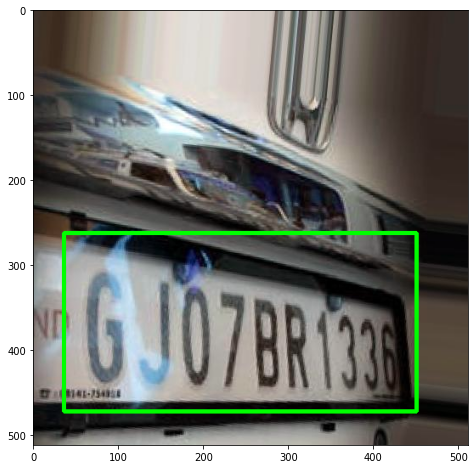

In [ ]:
img = cv2.imread(df['images'][0])
cv2.rectangle(img,(36,262),(451,472),(0,255,0),3)
plt.figure(figsize=(10,8))
plt.imshow(img)

# **DATA NORMALIZATION**

In [ ]:
labels = df.iloc[:,1:].values#takes all the columns except with 0 index and converting it into an array
labels[0:5]

array([[ 36, 451, 262, 472],
       [137, 301, 176, 263],
       [209, 396, 191, 317],
       [115, 216, 121, 187],
       [283, 407, 401, 487]])

In [ ]:
data = []
output = []
for ind in range(len(df['images'])):
    image = df['images'][ind]
    load_image = load_img(image,target_size=(512,512))
    load_image_arr = img_to_array(load_image)
    h,w,d = load_image_arr.shape
    #Normalizing the input image array
    norm_load_image_arr = load_image_arr/255.0
    #Normalizing the bounding_box_values/labels
    xmin,xmax,ymin,ymax = labels[ind]
    nxmin,nxmax = xmin/w,xmax/w
    nymin,nymax = ymin/h,ymax/h
    label_norm = (nxmin,nxmax,nymin,nymax)
    data.append(norm_load_image_arr)
    output.append(label_norm)

In [ ]:
d = dict(inputs=data,labels=output)

In [ ]:
df = pd.DataFrame(d)

In [ ]:
df

,inputs,labels
0,"[[[0.16862746, 0.19607843, 0.23529412], [0.172...","(0.0703125, 0.880859375, 0.51171875, 0.921875)"
1,"[[[0.0, 0.101960786, 0.09803922], [0.0, 0.0, 0...","(0.267578125, 0.587890625, 0.34375, 0.513671875)"
2,"[[[0.6862745, 0.6901961, 0.69803923], [0.55686...","(0.408203125, 0.7734375, 0.373046875, 0.619140..."
3,"[[[0.47058824, 0.40392157, 0.3254902], [0.4627...","(0.224609375, 0.421875, 0.236328125, 0.365234375)"
4,"[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,...","(0.552734375, 0.794921875, 0.783203125, 0.9511..."
...,...,...
1495,"[[[0.10980392, 0.05490196, 0.019607844], [0.11...","(0.4921875, 0.630859375, 0.705078125, 0.77734375)"
1496,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","(0.611328125, 0.8203125, 0.51953125, 0.60546875)"
1497,"[[[0.627451, 0.67058825, 0.6784314], [0.627451...","(0.26171875, 0.412109375, 0.6171875, 0.705078125)"
1498,"[[[0.0627451, 0.08235294, 0.05882353], [0.0588...","(0.521484375, 0.85546875, 0.435546875, 0.59570..."


In [ ]:
print(df['inputs'][0].shape)
print(type(df['inputs'][0]))

In [ ]:
type(df['labels'][0])

Converting the data and output to numpy array

In [ ]:
X = np.array(data, dtype=np.float32)
Y = np.array(output, dtype=np.float32)

In [ ]:
X.shape, Y.shape

((1500, 512, 512, 3), (1500, 4))

Train Test split

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(X,Y,train_size=0.8,random_state=0)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((1200, 512, 512, 3), (300, 512, 512, 3), (1200, 4), (300, 4))

# **MODEL BUILDING**

VGG16

In [ ]:
vgg_16 = VGG16(weights='imagenet',include_top=False,input_tensor=Input(shape=(512,512,3)))

In [ ]:
vgg_16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 512, 512, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 512, 512, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 256, 256, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 256, 256, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 256, 256, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, 128, 128)     0     

In [ ]:
vgg_16.trainable=False

In [ ]:
vgg_16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 512, 512, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 512, 512, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 256, 256, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 256, 256, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 256, 256, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, 128, 128)     0     

In [ ]:
headmodel = vgg_16.output
headmodel = Flatten()(headmodel)
headmodel = Dense(500,activation='relu')(headmodel)
headmodel = Dense(250,activation='relu')(headmodel)
headmodel = Dense(4,activation='sigmoid')(headmodel)
vgg_16_model = Model(inputs = vgg_16.input, outputs = headmodel)

In [ ]:
vgg_16_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 512, 512, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 512, 512, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 256, 256, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 256, 256, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 256, 256, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, 128, 128)     0     

In [ ]:
vgg_16_model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),metrics=['accuracy'])

In [ ]:
history = vgg_16_model.fit(x=x_train,y=y_train,batch_size=10,epochs=30,validation_data=(x_test,y_test))

Epoch 1/30
120/120 [==============================] - 38s 160ms/step - loss: 0.1155 - accuracy: 8.3333e-04 - val_loss: 0.1056 - val_accuracy: 0.0000e+00
Epoch 2/30
120/120 [==============================] - 19s 159ms/step - loss: 0.1111 - accuracy: 0.0000e+00 - val_loss: 0.1026 - val_accuracy: 0.0000e+00
Epoch 3/30
120/120 [==============================] - 19s 160ms/step - loss: 0.0872 - accuracy: 0.2600 - val_loss: 0.0482 - val_accuracy: 0.8200
Epoch 4/30
120/120 [==============================] - 19s 161ms/step - loss: 0.0208 - accuracy: 0.7475 - val_loss: 0.0101 - val_accuracy: 0.8967
Epoch 5/30
120/120 [==============================] - 19s 161ms/step - loss: 0.0064 - accuracy: 0.8083 - val_loss: 0.0068 - val_accuracy: 0.8633
Epoch 6/30
120/120 [==============================] - 19s 161ms/step - loss: 0.0030 - accuracy: 0.8800 - val_loss: 0.0068 - val_accuracy: 0.8900
Epoch 7/30
120/120 [==============================] - 19s 161ms/step - loss: 0.0021 - accuracy: 0.9250 - val_loss:

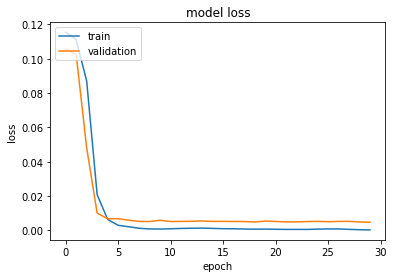

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

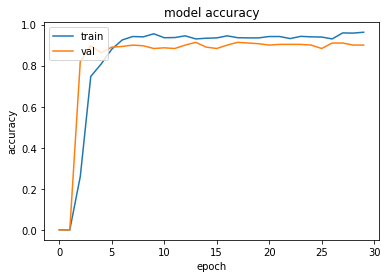

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## **INCEPTION_RESNET_V2**

In [ ]:
Incept_resnet_v2_top = InceptionResNetV2(weights='imagenet',include_top=False,input_tensor=Input(shape=(512,512,3)))

In [ ]:
Incept_resnet_v2_top.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d_297 (Conv2D)             (None, 255, 255, 32) 864         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_297 (BatchN (None, 255, 255, 32) 96          conv2d_297[0][0]                 
__________________________________________________________________________________________________
activation_297 (Activation)     (None, 255, 255, 32) 0           batch_normalization_297[0][0]    
________________________________________________________________________________

In [ ]:
Incept_resnet_v2_top.trainable = False

In [ ]:
Incept_resnet_v2_top.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d_297 (Conv2D)             (None, 255, 255, 32) 864         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_297 (BatchN (None, 255, 255, 32) 96          conv2d_297[0][0]                 
__________________________________________________________________________________________________
activation_297 (Activation)     (None, 255, 255, 32) 0           batch_normalization_297[0][0]    
________________________________________________________________________________

In [ ]:
headmodel = Incept_resnet_v2_top.output
headmodel = Flatten()(headmodel)
headmodel = Dense(500,activation='relu')(headmodel)
headmodel = Dense(250,activation='relu')(headmodel)
headmodel = Dense(4,activation='sigmoid')(headmodel)
Incept_resnet_v2_model = Model(inputs = Incept_resnet_v2_top.input,outputs = headmodel)

In [ ]:
Incept_resnet_v2_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d_297 (Conv2D)             (None, 255, 255, 32) 864         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_297 (BatchN (None, 255, 255, 32) 96          conv2d_297[0][0]                 
__________________________________________________________________________________________________
activation_297 (Activation)     (None, 255, 255, 32) 0           batch_normalization_297[0][0]    
____________________________________________________________________________________________

In [ ]:
Incept_resnet_v2_model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),metrics=['accuracy'])

In [ ]:
history = Incept_resnet_v2_model.fit(x=x_train,y=y_train,batch_size=10,epochs=50,validation_data=(x_test,y_test))

Epoch 1/50
120/120 [==============================] - 41s 268ms/step - loss: 0.1754 - accuracy: 0.4825 - val_loss: 0.1928 - val_accuracy: 0.4833
Epoch 2/50
120/120 [==============================] - 29s 241ms/step - loss: 0.1902 - accuracy: 0.4975 - val_loss: 0.1928 - val_accuracy: 0.4833
Epoch 3/50
120/120 [==============================] - 29s 241ms/step - loss: 0.1821 - accuracy: 0.4658 - val_loss: 0.1663 - val_accuracy: 0.4833
Epoch 4/50
120/120 [==============================] - 29s 241ms/step - loss: 0.1702 - accuracy: 0.4625 - val_loss: 0.1667 - val_accuracy: 0.4833
Epoch 5/50
120/120 [==============================] - 29s 241ms/step - loss: 0.1702 - accuracy: 0.4625 - val_loss: 0.1667 - val_accuracy: 0.4833
Epoch 6/50
120/120 [==============================] - 29s 240ms/step - loss: 0.1704 - accuracy: 0.4625 - val_loss: 0.1667 - val_accuracy: 0.4833
Epoch 7/50
120/120 [==============================] - 29s 240ms/step - loss: 0.1704 - accuracy: 0.4625 - val_loss: 0.1667 - val_ac

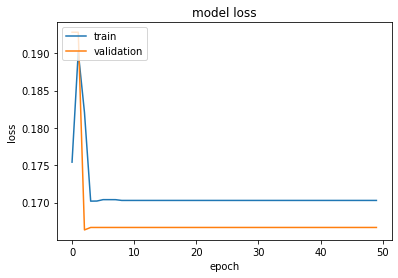

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

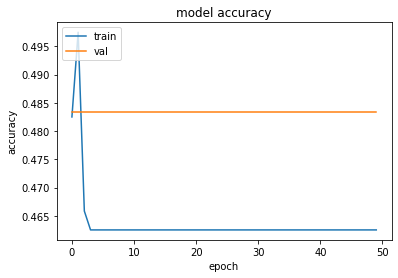

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# model.save('/content/drive/MyDrive/models/ANPRINCEPT_RESNET_V2.h5')

In [ ]:
# model.save('/content/drive/MyDrive/models/ANPRVGG16.h5')

## **VGG19**

In [ ]:
vgg_19 = VGG19(weights='imagenet',include_top=False,input_tensor=Input(shape=(512,512,3)))

In [ ]:
vgg_19.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 512, 512, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 512, 512, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 256, 256, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 256, 256, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 256, 256, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, 128, 128)     0     

In [ ]:
vgg_19.trainable=False

In [ ]:
vgg_19.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 512, 512, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 512, 512, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 256, 256, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 256, 256, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 256, 256, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, 128, 128)     0     

In [ ]:
headmodel = vgg_19.output
headmodel = Flatten()(headmodel)
headmodel = Dense(500,activation='relu')(headmodel)
headmodel = Dense(250,activation='relu')(headmodel)
headmodel = Dense(4,activation='sigmoid')(headmodel)
vgg_19_model = Model(inputs = vgg_19.input, outputs = headmodel)

In [ ]:
vgg_19_model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 512, 512, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 512, 512, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 256, 256, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 256, 256, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 256, 256, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, 128, 128)     0   

In [ ]:
vgg_19_model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),metrics=['accuracy'])

In [ ]:
history = vgg_19_model.fit(x=x_train,y=y_train,batch_size=10,epochs=50,validation_data=(x_test,y_test))

Epoch 1/50
120/120 [==============================] - 24s 196ms/step - loss: 0.1875 - accuracy: 0.4567 - val_loss: 0.1928 - val_accuracy: 0.4833
Epoch 2/50
120/120 [==============================] - 23s 195ms/step - loss: 0.1899 - accuracy: 0.4683 - val_loss: 0.1928 - val_accuracy: 0.4833
Epoch 3/50
120/120 [==============================] - 23s 195ms/step - loss: 0.1899 - accuracy: 0.4683 - val_loss: 0.1928 - val_accuracy: 0.4833
Epoch 4/50
120/120 [==============================] - 23s 195ms/step - loss: 0.1899 - accuracy: 0.4683 - val_loss: 0.1928 - val_accuracy: 0.4833
Epoch 5/50
120/120 [==============================] - 23s 195ms/step - loss: 0.1899 - accuracy: 0.4683 - val_loss: 0.1928 - val_accuracy: 0.4833
Epoch 6/50
120/120 [==============================] - 23s 195ms/step - loss: 0.1899 - accuracy: 0.4675 - val_loss: 0.1928 - val_accuracy: 0.4833
Epoch 7/50
120/120 [==============================] - 23s 195ms/step - loss: 0.1899 - accuracy: 0.4675 - val_loss: 0.1928 - val_ac

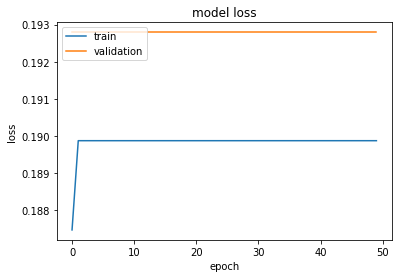

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

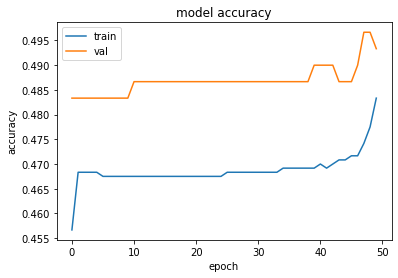

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# model.save('/content/drive/MyDrive/models/ANPRVGG19.h5')

## **RESNET50**

In [ ]:
res = ResNet50(weights='imagenet',include_top=False,input_tensor=Input(shape=(512,512,3)))

In [ ]:
res.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 518, 518, 3)  0           input_9[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 256, 256, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 256, 256, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
res.trainable=False

In [ ]:
res.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 518, 518, 3)  0           input_9[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 256, 256, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 256, 256, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
headmodel = res.output
headmodel = Flatten()(headmodel)
headmodel = Dense(500,activation='relu')(headmodel)
headmodel = Dense(250,activation='relu')(headmodel)
headmodel = Dense(4,activation='sigmoid')(headmodel)
res_model = Model(inputs = res.input,outputs = headmodel)

In [ ]:
res_model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 518, 518, 3)  0           input_9[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 256, 256, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 256, 256, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
res_model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),metrics=['accuracy'])

In [ ]:
history = res_model.fit(x=x_train,y=y_train,batch_size=10,epochs=30,validation_data=(x_test,y_test))

Epoch 1/50
120/120 [==============================] - 18s 135ms/step - loss: 0.1896 - accuracy: 0.4608 - val_loss: 0.1928 - val_accuracy: 0.4833
Epoch 2/50
120/120 [==============================] - 15s 129ms/step - loss: 0.1899 - accuracy: 0.4625 - val_loss: 0.1928 - val_accuracy: 0.4833
Epoch 3/50
120/120 [==============================] - 15s 129ms/step - loss: 0.1899 - accuracy: 0.4625 - val_loss: 0.1928 - val_accuracy: 0.4833
Epoch 4/50
120/120 [==============================] - 15s 129ms/step - loss: 0.1899 - accuracy: 0.4625 - val_loss: 0.1928 - val_accuracy: 0.4833
Epoch 5/50
120/120 [==============================] - 15s 129ms/step - loss: 0.1899 - accuracy: 0.4625 - val_loss: 0.1928 - val_accuracy: 0.4833
Epoch 6/50
120/120 [==============================] - 15s 129ms/step - loss: 0.1899 - accuracy: 0.4625 - val_loss: 0.1928 - val_accuracy: 0.4833
Epoch 7/50
120/120 [==============================] - 15s 129ms/step - loss: 0.1899 - accuracy: 0.4625 - val_loss: 0.1928 - val_ac

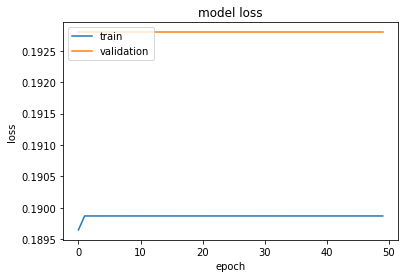

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

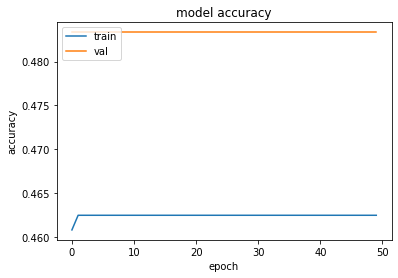

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# model.save('/content/drive/MyDrive/models/ANPR_RESNET50.h5')

## **INCEPTIONV3**

In [ ]:
incept = InceptionV3(weights='imagenet',include_top=False,input_tensor=Input(shape=(512,512,3)))

In [ ]:
incept.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d_500 (Conv2D)             (None, 255, 255, 32) 864         input_10[0][0]                   
__________________________________________________________________________________________________
batch_normalization_500 (BatchN (None, 255, 255, 32) 96          conv2d_500[0][0]                 
__________________________________________________________________________________________________
activation_500 (Activation)     (None, 255, 255, 32) 0           batch_normalization_500[0][0]    
_______________________________________________________________________________________

In [ ]:
incept.trainable=False

In [ ]:
incept.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d_500 (Conv2D)             (None, 255, 255, 32) 864         input_10[0][0]                   
__________________________________________________________________________________________________
batch_normalization_500 (BatchN (None, 255, 255, 32) 96          conv2d_500[0][0]                 
__________________________________________________________________________________________________
activation_500 (Activation)     (None, 255, 255, 32) 0           batch_normalization_500[0][0]    
_______________________________________________________________________________________

In [ ]:
headmodel = incept.output
headmodel = Flatten()(headmodel)
headmodel = Dense(500,activation='relu')(headmodel)
headmodel = Dense(250,activation='relu')(headmodel)
headmodel = Dense(4,activation='sigmoid')(headmodel)
incept_model = Model(inputs = incept.input,outputs = headmodel)

In [ ]:
incept_model.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d_500 (Conv2D)             (None, 255, 255, 32) 864         input_10[0][0]                   
__________________________________________________________________________________________________
batch_normalization_500 (BatchN (None, 255, 255, 32) 96          conv2d_500[0][0]                 
__________________________________________________________________________________________________
activation_500 (Activation)     (None, 255, 255, 32) 0           batch_normalization_500[0][0]    
____________________________________________________________________________________________

In [ ]:
incept_model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),metrics=['accuracy'])

In [ ]:
history = incept_model.fit(x=x_train,y=y_train,batch_size=10,epochs=30,validation_data=(x_test,y_test))

Epoch 1/30
120/120 [==============================] - 18s 118ms/step - loss: 0.2940 - accuracy: 0.0192 - val_loss: 0.2996 - val_accuracy: 0.0000e+00
Epoch 2/30
120/120 [==============================] - 13s 110ms/step - loss: 0.3042 - accuracy: 0.0000e+00 - val_loss: 0.2941 - val_accuracy: 0.0000e+00
Epoch 3/30
120/120 [==============================] - 13s 110ms/step - loss: 0.2576 - accuracy: 0.1275 - val_loss: 0.2306 - val_accuracy: 0.0133
Epoch 4/30
120/120 [==============================] - 13s 110ms/step - loss: 0.2381 - accuracy: 0.0092 - val_loss: 0.2397 - val_accuracy: 0.0000e+00
Epoch 5/30
120/120 [==============================] - 13s 110ms/step - loss: 0.2446 - accuracy: 0.1092 - val_loss: 0.2231 - val_accuracy: 0.0867
Epoch 6/30
120/120 [==============================] - 13s 110ms/step - loss: 0.2339 - accuracy: 0.0233 - val_loss: 0.2315 - val_accuracy: 0.0067
Epoch 7/30
120/120 [==============================] - 13s 110ms/step - loss: 0.2287 - accuracy: 0.0333 - val_loss:

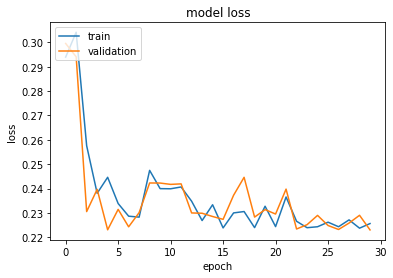

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

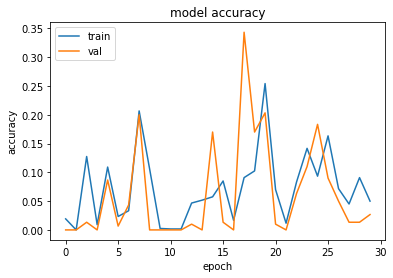

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
vgg_16_model.save('/content/drive/MyDrive/models/ANPR_VGG16.h5')

EVALUATIING PERFORMANCE OF MODELS:

In [39]:
model_path = '/content/drive/MyDrive/models/ANPR_VGG16.h5'

In [40]:
vgg_16_model = keras.models.load_model(model_path)

Evaluating on test data:

In [ ]:
test_data = dict(images=[],xmin=[],xmax=[],ymin=[],ymax=[])#dictionary which stores image_name and its path and its bounding boxes values by parsing the xml
for filename in test:
  info = xet.parse(filename)#creating a parser for the current xml file
  root = info.getroot()#getting a root, so that we can traverse using this root to read and manipulate the content
  img_name = root.find('filename').text
  img_path = "/content/drive/MyDrive/preview/"+img_name
  test_data['images'].append(img_path)
  member_object = root.find("object")#finding the "object" tag in the given xml file
  labels_info = member_object.find("bndbox")#finding the "bndbox" tage under the "object" tag
  xmin = int(labels_info.find('xmin').text)#reading the "xmin" value under the "bndbox" tag
  xmax = int(labels_info.find('xmax').text)
  ymin = int(labels_info.find('ymin').text)
  ymax = int(labels_info.find('ymax').text)
  test_data['xmin'].append(xmin)
  test_data['xmax'].append(xmax)
  test_data['ymin'].append(ymin)
  test_data['ymax'].append(ymax)

In [ ]:
test_df = pd.DataFrame(test_data)

In [ ]:
test_df

,images,xmin,xmax,ymin,ymax
0,/content/drive/MyDrive/preview/car_0_2980.jpeg,124,296,338,398
1,/content/drive/MyDrive/preview/car_0_2981.jpeg,125,306,399,485
2,/content/drive/MyDrive/preview/car_0_2985.jpeg,83,216,249,317
3,/content/drive/MyDrive/preview/car_0_2987.jpeg,65,214,308,342
4,/content/drive/MyDrive/preview/car_0_2998.jpeg,113,224,430,475
...,...,...,...,...,...
95,/content/drive/MyDrive/preview/car_0_3396.jpeg,295,387,201,248
96,/content/drive/MyDrive/preview/car_0_3399.jpeg,314,411,409,452
97,/content/drive/MyDrive/preview/car_0_3401.jpeg,233,397,173,252
98,/content/drive/MyDrive/preview/car_0_3406.jpeg,258,360,433,481


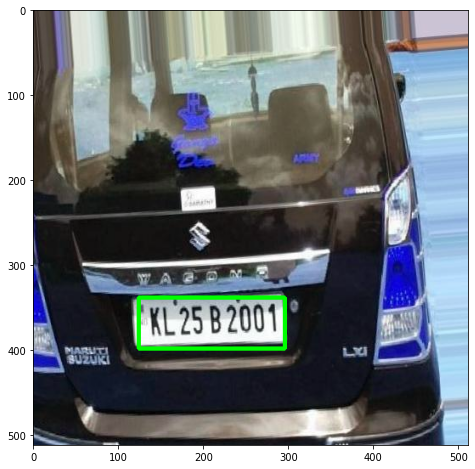

In [ ]:
img_arr = cv2.imread(test_df['images'][0])
cv2.rectangle(img_arr,(124,338),(296,398),(0,255,0),3)
plt.figure(figsize=(10,8))
plt.imshow(img_arr)


TEST_DATA_NORMALIZATION

In [ ]:
test_labels = test_df.iloc[:,1:].values#takes all the columns except with 0 index and converting it into an array
test_labels[0:5]

array([[124, 296, 338, 398],
       [125, 306, 399, 485],
       [ 83, 216, 249, 317],
       [ 65, 214, 308, 342],
       [113, 224, 430, 475]])

In [ ]:
test_data = []
test_output = []
for ind in range(len(test_df['images'])):
    image = test_df['images'][ind]
    load_image = load_img(image,target_size=(512,512))
    load_image_arr = img_to_array(load_image)
    h,w,d = load_image_arr.shape
    #Normalizing the input image array
    norm_load_image_arr = load_image_arr/255.0
    #Normalizing the bounding_box_values/labels
    xmin,xmax,ymin,ymax = test_labels[ind]
    nxmin,nxmax = xmin/w,xmax/w
    nymin,nymax = ymin/h,ymax/h
    label_norm = (nxmin,nxmax,nymin,nymax)
    test_data.append(norm_load_image_arr)
    test_output.append(label_norm)

In [ ]:
d = dict(test_inputs=test_data,test_labels=test_output)

In [ ]:
test_dataframe = pd.DataFrame(d)

In [ ]:
test_dataframe

,test_inputs,test_labels
0,"[[[0.20784314, 0.22352941, 0.26666668], [0.109...","(0.2421875, 0.578125, 0.66015625, 0.77734375)"
1,"[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,...","(0.244140625, 0.59765625, 0.779296875, 0.94726..."
2,"[[[0.91764706, 0.9882353, 0.99607843], [0.9490...","(0.162109375, 0.421875, 0.486328125, 0.619140625)"
3,"[[[0.8117647, 0.83137256, 0.84705883], [0.8117...","(0.126953125, 0.41796875, 0.6015625, 0.66796875)"
4,"[[[0.63529414, 0.6, 0.5647059], [0.61960787, 0...","(0.220703125, 0.4375, 0.83984375, 0.927734375)"
...,...,...
95,"[[[0.4745098, 0.39607844, 0.2901961], [0.47450...","(0.576171875, 0.755859375, 0.392578125, 0.484375)"
96,"[[[0.050980393, 0.07058824, 0.047058824], [0.0...","(0.61328125, 0.802734375, 0.798828125, 0.8828125)"
97,"[[[0.09411765, 0.09019608, 0.14509805], [0.094...","(0.455078125, 0.775390625, 0.337890625, 0.4921..."
98,"[[[0.26666668, 0.3254902, 0.24313726], [0.2588...","(0.50390625, 0.703125, 0.845703125, 0.939453125)"


In [ ]:
test_X = np.array(test_data, dtype=np.float32)
test_Y = np.array(test_output, dtype=np.float32)

In [ ]:
test_X.shape, test_Y.shape

((100, 512, 512, 3), (100, 4))

In [ ]:
score = vgg_16_model.evaluate(test_X, test_Y, verbose = 0) 

In [ ]:
print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

Test loss: 0.005581700708717108
Test accuracy: 0.9200000166893005


Verfying the model with new data

In [ ]:
lis_xml[2010]

'/content/drive/MyDrive/preview/N120.xml'

In [ ]:
info = xet.parse(lis_xml[2010])#creating a parser for the current xml file
root = info.getroot()#getting a root, so that we can traverse using this root to read and manipulate the content
img_name = root.find('filename').text
img_path = "/content/drive/MyDrive/preview/"+img_name

In [74]:
img_path = "/pexels-mike-244279.jpg"

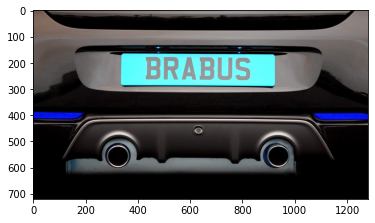

<Figure size 720x576 with 0 Axes>

In [75]:
imag = cv2.imread("/pexels-mike-244279.jpg")
plt.imshow(imag)
plt.figure(figsize=(10,8))
plt.show()

predicting:

In [76]:
load_image = load_img(img_path,target_size=(512,512))
load_image_arr = img_to_array(load_image)/255.0

In [77]:
img = cv2.imread(img_path)
h,w,d = img.shape

In [78]:
(h,w,d)

(720, 1280, 3)

In [79]:
test_img_reshaped = load_image_arr.reshape(1,512,512,3)
test_img_reshaped.shape

(1, 512, 512, 3)

In [80]:
coords = vgg_16_model.predict(test_img_reshaped)
coords

array([[0.27275136, 0.7393173 , 0.31430444, 0.5432365 ]], dtype=float32)

In [81]:
#denormalizing the output
denorm  = np.array([w,w,h,h])
coords = coords*denorm#element wise multiplication

In [82]:
print(coords)

[[349.12174225 946.32614136 226.29919767 391.13027573]]


In [83]:
coords = coords.astype(np.int32)
coords

array([[349, 946, 226, 391]], dtype=int32)

(349, 226) (946, 391)


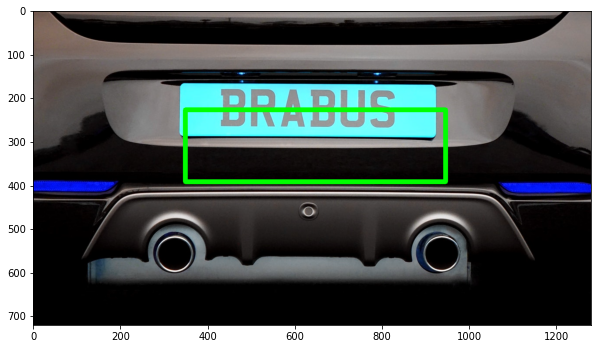

In [84]:
xmin,xmax,ymin,ymax = coords[0]
pt1=(xmin,ymin)
pt2=(xmax,ymax)
print(pt1,pt2)
cv2.rectangle(img,pt1,pt2,(0,255,0),10)
plt.figure(figsize=(10,8))
plt.imshow(img)
plt.show()

## **OCR**

In [85]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [86]:
try:
  from PIL import Image
except ImportError:
  import Image
import pytesseract

In [87]:
path="/pexels-mike-132548.jpg"

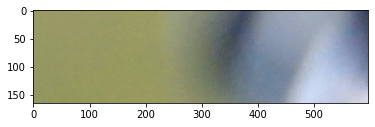

In [88]:
xmin,xmax,ymin,ymax = coords[0]
img_arr = np.array(load_img(path))
roi = img_arr[ymin:ymax,xmin:xmax]
plt.imshow(roi)
plt.show()

In [64]:
roi_color = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)

In [68]:
path = roi_color

In [65]:
data = Image.fromarray(roi_color)
data.save("/content/drive/MyDrive/test/data.jpeg")

In [89]:
extract = pytesseract.image_to_string(Image.open("/pexels-mike-244279.jpg"))
print(extract)